In [247]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, ff_nn#, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, plotmesh, merge_weights_aniso
from utils_hyperelasticity import NODE, init_layers

import GPy
from jaxinterp2d import interp2d

from scipy.optimize import fsolve

In [2]:
n = 20
x_gt = np.linspace(0,1,n)[:,None]
k = GPy.kern.RBF(input_dim=1,lengthscale=0.4)
mu = np.zeros((n)) 
C = k.K(x_gt,x_gt) 
eps_gt = np.random.multivariate_normal(mu,C,1)*0.03+0.15

x_gt = x_gt.flatten()
eps_gt = eps_gt.flatten()

Fx = np.random.uniform()+0.5

Text(0.5, 1.0, 'Reaction force = 1.401')

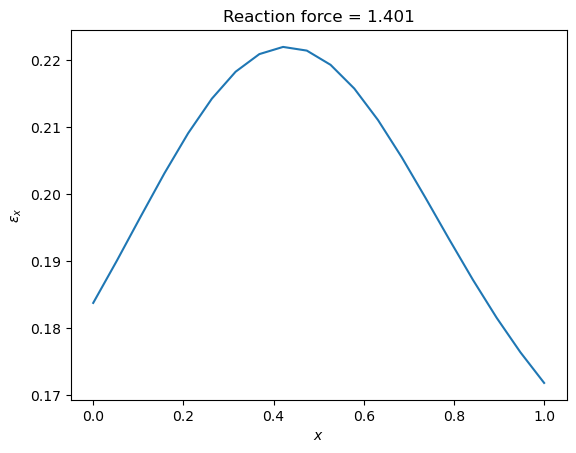

In [3]:
plt.plot(x_gt,eps_gt)
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.title('Reaction force = {}'.format(np.round(Fx, 3)))

### Incompressible neo-Hookean

$$ \Psi(\mathbf{F}, x) = \mu(x)(I_1(x)-3) $$

$$ \boldsymbol{\sigma} = -p\mathbf{I} + \mu \mathbf{b} $$

under uniaxial loading $\lambda_y = \lambda_z = 1/\sqrt{\lambda}, \lambda_x = \lambda$ and $\mathbf{b} = \mathrm{diag}(\lambda^2, 1/\lambda, 1/\lambda)$ then,

$$ p = \frac{\mu}{\lambda} $$ 

from boundary conditions. And finally,

$$ \sigma_{xx} = \mu \lambda^2 - \frac{\mu}{\lambda} $$

In [4]:
def nn_fpass(H, params):
    Ws, bs = params
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = jnp.matmul(H, Ws[i]) + bs[i]
        H = jnp.tanh(H)
    H = jnp.matmul(H, Ws[-1]) + bs[-1]
    return H

def init_params_nn(layers, key):
    Ws = []
    bs = []
    for i in range(len(layers) - 1):
      std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
      key, subkey = random.split(key)
      Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
      bs.append(jnp.zeros(layers[i + 1]))
    return [Ws, bs]
    
def get_stress_neoHook(x, Lambda_params):
    eps = jnp.interp(x, x_gt, eps_gt)
    lmb = 1.0+eps
    mu = nn_fpass(x, Lambda_params)
    sgmx = mu*lmb**2 - mu/lmb
    return sgmx[0]
get_stress_neoHook_vmap = vmap(get_stress_neoHook, in_axes=(0,None), out_axes=(0,))

### Loss function: 2 objectives
#### 1. Balance of linear momentum

$$ \nabla \cdot \boldsymbol{\sigma} + \rho \mathbf{f} = 0 $$

in the absence of body forces $\mathbf{f}$ and in 1D this becomes

$$ \frac{\partial \sigma_{xx}}{\partial x} = 0 $$


#### 2. Satisfying reaction forces

$$ \int_{\text{bd}} \sigma_{xx} dA = F_{\text{react.}} $$

Then the loss function is defined as

$$ L(\phi) = \left( \frac{\partial \sigma_{xx}}{\partial x} \right)^2 + (\sigma_{xx}(0) \cdot A - F_{\text{react.}})^2 + (\sigma_{xx}(L) \cdot A - F_{\text{react.}})^2 $$

In [6]:
divergence_1d = vmap(grad(get_stress_neoHook, argnums=0), in_axes=(0,None), out_axes=0)

def loss(Lambda_params, input, key):
    # get divergence across the domain
    x_colloc = random.uniform(key, (20,1))
    div = divergence_1d(x_colloc, Lambda_params)

    # get stress at 0 & L
    sgm0 = get_stress_neoHook(x_gt[ 0,None], Lambda_params)
    sgmL = get_stress_neoHook(x_gt[-1,None], Lambda_params)
    return 1*jnp.sum(div**2) + 10*((sgm0*1 - Fx)**2 + (sgmL*1-Fx)**2) # Assuming CS Area = 1


Lambda_layers = [1,3,3,1]
key = random.PRNGKey(0)
Lambda_params = init_params_nn(Lambda_layers, key)

opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, metrics = train(loss, None, get_params, opt_update, opt_state, key, nIter = 500000, print_freq=10000)

it 10000, train loss = 2.892031e+01
it 20000, train loss = 2.010379e+01
it 30000, train loss = 1.150338e+01
it 40000, train loss = 8.727519e+00
it 50000, train loss = 6.136856e+00
it 60000, train loss = 4.015734e+00
it 70000, train loss = 1.580750e+00
it 80000, train loss = 4.111290e-01
it 90000, train loss = 1.047629e-01
it 100000, train loss = 5.254107e-02
it 110000, train loss = 5.868112e-02
it 120000, train loss = 6.801258e-02
it 130000, train loss = 4.076194e-02
it 140000, train loss = 6.978488e-02
it 150000, train loss = 3.146234e-02
it 160000, train loss = 5.331453e-02
it 170000, train loss = 4.178860e-02
it 180000, train loss = 4.763213e-02
it 190000, train loss = 2.866418e-02
it 200000, train loss = 5.733365e-02
it 210000, train loss = 5.129479e-02
it 220000, train loss = 3.876953e-02
it 230000, train loss = 3.523414e-02
it 240000, train loss = 3.253960e-02
it 250000, train loss = 3.958001e-02
it 260000, train loss = 4.469957e-02
it 270000, train loss = 3.289133e-02
it 280000,

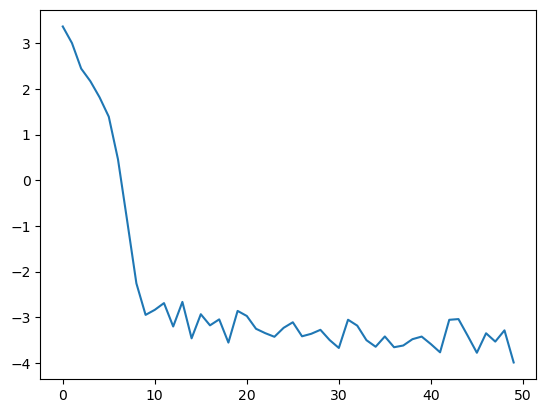

In [7]:
plt.plot(np.log(train_loss))

In [8]:
def get_strain_neoHook(x, Lambda_params): # Invert the get_stress_neoHook function to get the strain for a given stress
    sgmx = Fx/1.0 #stress is constant for the domain
    mu = nn_fpass(x, Lambda_params)
    
    invertsgm = lambda lmb: mu*lmb**2 - mu/lmb - sgmx
    lmb = fsolve(invertsgm, x0 = 1.0)
    return lmb-1.0

eps_pr = []
for i in range(len(x_gt)):
    eps_pr.append(get_strain_neoHook(x_gt[i,None], Lambda_params)[0])

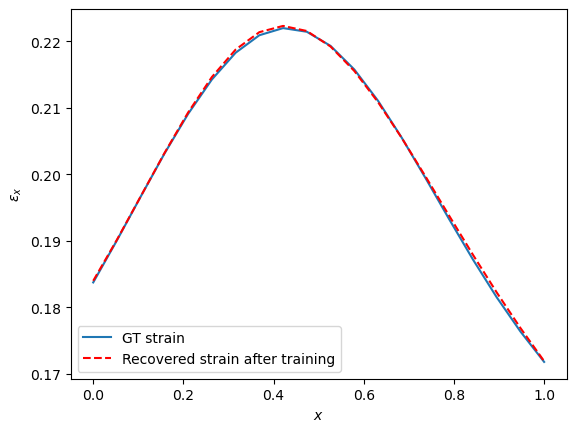

In [9]:
plt.plot(x_gt, eps_gt, label='GT strain')
plt.plot(x_gt, eps_pr, 'r--', label='Recovered strain after training')
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.legend()

(1.1210531882101193, 1.681579782315179)

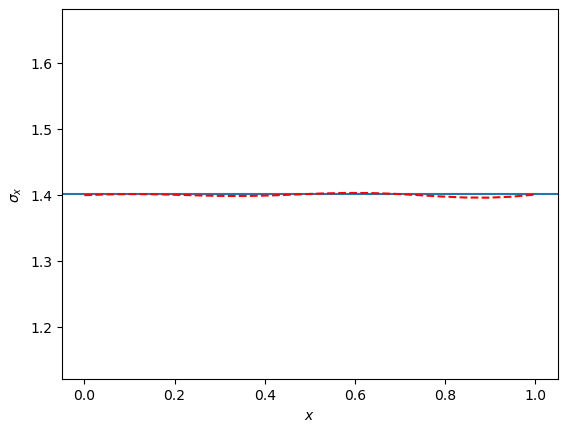

In [10]:
sgm_pr = []
for i in range(len(x_gt)):
    sgm_pr.append(get_stress_neoHook(x_gt[i,None], Lambda_params))
plt.axhline(Fx, label='GT stress')
plt.plot(x_gt, sgm_pr, 'r--', label='Stress calculated after training')
plt.xlabel('$x$')
plt.ylabel('$\sigma_{x}$')
plt.ylim([Fx*0.8, Fx*1.2])

#### Neural ODE

In [11]:
def get_stress_node(x, Lambda_params):
    eps = jnp.interp(x, x_gt, eps_gt)
    lmb = 1.0+eps
    I1 = lmb**2 + 1/lmb + 1/lmb
    phi = nn_fpass(x, Lambda_params)
    Psi1 = NODE(I1, unravel(phi))
    sgmx = Psi1*(lmb**2 - 1/lmb)
    return sgmx[0]
get_stress_node_vmap = vmap(get_stress_node, in_axes=(0,None), out_axes=(0,))
divergence_1d = vmap(grad(get_stress_node, argnums=0), in_axes=(0,None), out_axes=0)

def loss(Lambda_params, input, key):
    # get divergence across the domain
    x_colloc = random.uniform(key, (20,1))
    div = divergence_1d(x_colloc, Lambda_params)

    # get stress at 0 & L
    sgm0 = get_stress_node(x_gt[ 0,None], Lambda_params)
    sgmL = get_stress_node(x_gt[-1,None], Lambda_params)
    return 1*jnp.sum(div**2) + 10*((sgm0*1 - Fx)**2 + (sgmL*1-Fx)**2) # Assuming CS Area = 1


common_layers = [1,3,3]
sample_layers = [3,1]
clayers = init_layers(common_layers, key)
slayers = init_layers(sample_layers, key) # I don't really want to do common layers and sample layers here, but I didn't want to modify my functions to accept a single set of layers.
dummy_phi = (clayers, slayers) 
aux, unravel = ravel_pytree(dummy_phi)

n_params = len(aux)
Lambda_layers = [1,3,3,n_params]
key = random.PRNGKey(0)
Lambda_params = init_params_nn(Lambda_layers, key)

opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, metrics = train(loss, None, get_params, opt_update, opt_state, key, nIter = 200000, print_freq=10000)

it 10000, train loss = 6.784290e+00
it 20000, train loss = 7.782200e-01
it 30000, train loss = 1.647695e-01
it 40000, train loss = 8.090572e-02
it 50000, train loss = 1.038366e-01
it 60000, train loss = 6.634529e-02
it 70000, train loss = 4.782626e-02
it 80000, train loss = 5.230531e-02
it 90000, train loss = 4.585888e-02
it 100000, train loss = 4.096535e-02
it 110000, train loss = 5.561669e-02
it 120000, train loss = 6.895329e-02
it 130000, train loss = 3.594139e-02
it 140000, train loss = 5.985993e-02
it 150000, train loss = 2.945204e-02
it 160000, train loss = 3.672140e-02
it 170000, train loss = 3.578065e-02
it 180000, train loss = 4.108056e-02
it 190000, train loss = 2.194343e-02
it 200000, train loss = 4.456180e-02


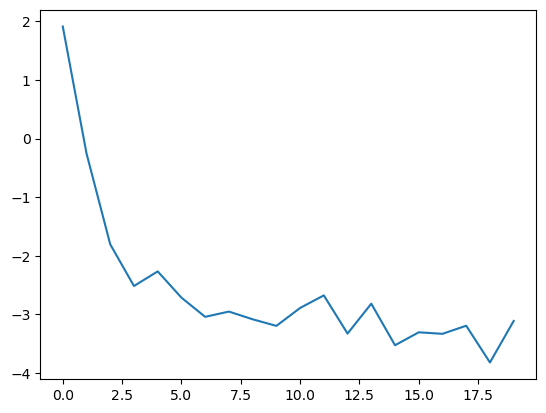

In [12]:
plt.plot(np.log(train_loss))

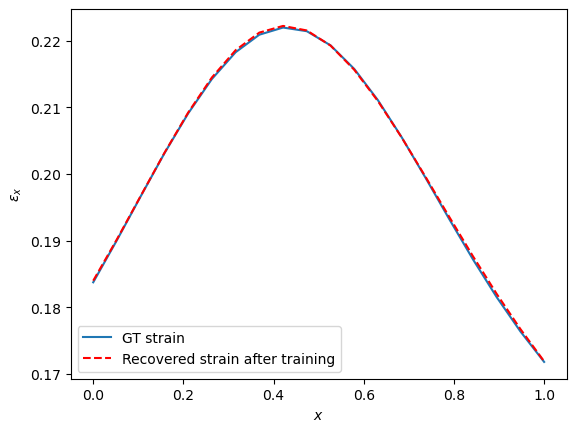

In [13]:
def get_strain_node(x, Lambda_params): # Invert the get_stress_neoHook function to get the strain for a given stress
    sgmx = Fx/1.0 #stress is constant for the domain
    phi = nn_fpass(x, Lambda_params)
    
    def invertsgm(lmb):
        I1 = lmb**2 + 1/lmb + 1/lmb
        Psi1 = NODE(I1, unravel(phi))
        return Psi1*(lmb**2 - 1/lmb) - sgmx
    lmb = fsolve(invertsgm, x0 = 1.0)
    return lmb-1.0

eps_pr = []
for i in range(len(x_gt)):
    eps_pr.append(get_strain_node(x_gt[i,None], Lambda_params)[0])


plt.plot(x_gt, eps_gt, label='GT strain')
plt.plot(x_gt, eps_pr, 'r--', label='Recovered strain after training')
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.legend()

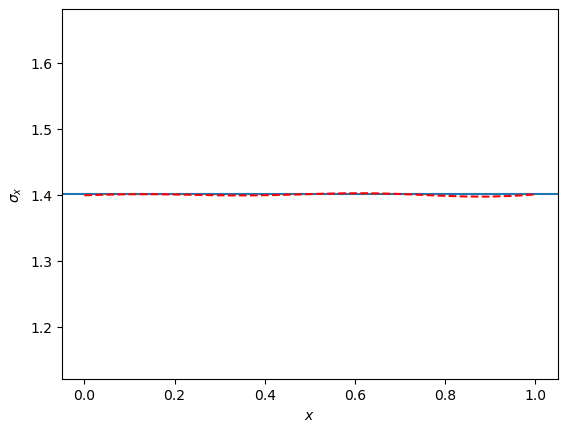

In [14]:
sgm_pr = []
for i in range(len(x_gt)):
    sgm_pr.append(get_stress_node(x_gt[i,None], Lambda_params))
plt.axhline(Fx, label='GT stress')
plt.plot(x_gt, sgm_pr, 'r--', label='Stress calculated after training')
plt.xlabel('$x$')
plt.ylabel('$\sigma_{x}$')
plt.ylim([Fx*0.8, Fx*1.2]); 

### Sharp transition

Text(0.5, 1.0, 'Reaction force = 0.692')

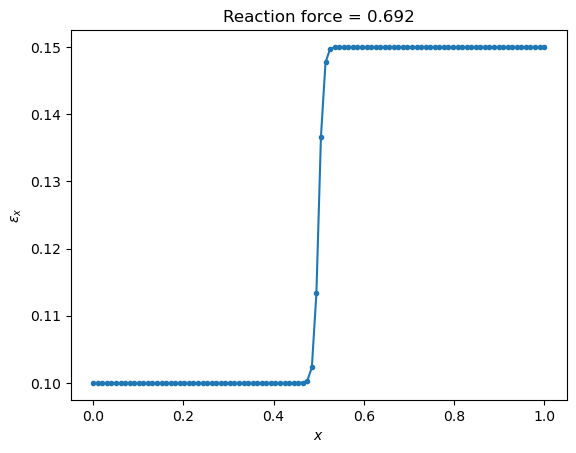

In [355]:
@jit
def u_gt_nz(x): # not zero at the boundary
    # this is the integral of a*sigmoid(b*(x-c)) + d strain  
    a = 0.05
    b = 200
    c = 0.5
    d = 0.1
    return (a + d)*x + (a*jnp.log(1 + jnp.exp(b*(c - x))))/(b*jnp.log(jnp.e))
u_gt = jit(lambda x: u_gt_nz(x) - u_gt_nz(0))

n = 100
x_gt = np.linspace(0,1,n)[:,None]
mu = np.zeros((n)) 

x_gt = x_gt.flatten()
eps_gt =  vmap(grad(u_gt))(x_gt).flatten()
np.random.seed(1234)
Fx = np.random.uniform()+0.5


plt.plot(x_gt,eps_gt, '.-')
plt.xlabel('$x$')
plt.ylabel('$\epsilon_{x}$')
plt.title('Reaction force = {}'.format(np.round(Fx, 3)))

In [248]:
def get_stress_neoHook(x, Lambda_params):
    eps = jnp.interp(x, x_gt, eps_gt)
    lmb = 1.0+eps
    mu = nn_fpass(x, Lambda_params)
    sgmx = mu*lmb**2 - mu/lmb
    return sgmx[0]

divergence_1d = vmap(grad(get_stress_neoHook, argnums=0), in_axes=(0,None), out_axes=0)

def loss(Lambda_params, input, key):
    # get divergence across the domain
    x_colloc = random.uniform(key, (20,1))
    div = divergence_1d(x_colloc, Lambda_params)

    # get stress at 0 & L
    sgm0 = get_stress_neoHook(x_gt[ 0,None], Lambda_params)
    sgmL = get_stress_neoHook(x_gt[-1,None], Lambda_params)
    return 1*jnp.sum(div**2) + 10*((sgm0*1 - Fx)**2 + (sgmL*1-Fx)**2) # Assuming CS Area = 1


Lambda_layers = [1,3,3,1]
key = random.PRNGKey(0)
Lambda_params = init_params_nn(Lambda_layers, key)

opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, metrics = train(loss, None, get_params, opt_update, opt_state, key, nIter = 500000, print_freq=10000)

it 10000, train loss = 8.963195e+00
it 20000, train loss = 5.927507e+00
it 30000, train loss = 7.641934e+00
it 40000, train loss = 5.740895e+00
it 50000, train loss = 5.165197e+00
it 60000, train loss = 6.044259e+00
it 70000, train loss = 9.223780e+00
it 80000, train loss = 6.303130e+00
it 90000, train loss = 4.836258e+00
it 100000, train loss = 5.300524e+00
it 110000, train loss = 4.848551e+00
it 120000, train loss = 5.255725e+00
it 130000, train loss = 5.212906e+00
it 140000, train loss = 6.544024e+00
it 150000, train loss = 6.532062e+00
it 160000, train loss = 9.544170e+00
it 170000, train loss = 1.006763e+01
it 180000, train loss = 5.035093e+00
it 190000, train loss = 9.681214e+00
it 200000, train loss = 4.608694e+00
it 210000, train loss = 4.629205e+00
it 220000, train loss = 7.378894e+00
it 230000, train loss = 5.126624e+00
it 240000, train loss = 4.549137e+00
it 250000, train loss = 4.687269e+00
it 260000, train loss = 4.924534e+00
it 270000, train loss = 6.136103e+00
it 280000,

[Text(0.5, 0, '$x$'),
 Text(0, 0.5, 'Div$P$'),
 Text(0.5, 1.0, 'Divergence along x')]

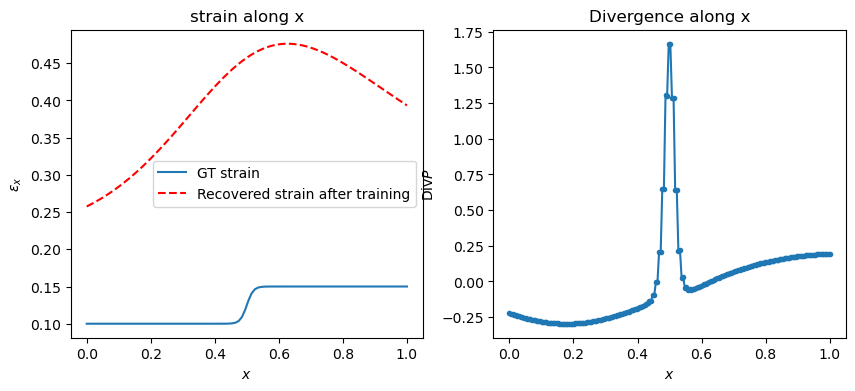

In [249]:
eps_pr = []
for i in range(len(x_gt)):
    eps_pr.append(get_strain_neoHook(x_gt[i,None], Lambda_params)[0])


fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(x_gt, eps_gt, label='GT strain')
ax[0].plot(x_gt, eps_pr, 'r--', label='Recovered strain after training')
ax[0].set(xlabel = '$x$', ylabel = '$\epsilon_{x}$', title='strain along x')
ax[0].legend()


x = np.linspace(0,1,200)
div = divergence_1d(x[:,None], Lambda_params)
ax[1].plot(x, div, '.-')
ax[1].set(xlabel = '$x$', ylabel='Div$P$', title='Divergence along x')

In [171]:
def gauss_quad_4(f, a, b):
    # Gaussian quadrature points and weights for 4 points
    nodes = jnp.array([-0.8611363115940526, -0.3399810435848563, 
                       0.3399810435848563,  0.8611363115940526])
    weights = jnp.array([0.3478548451374539, 0.6521451548625461, 
                         0.6521451548625461, 0.3478548451374539])
    
    # Transform nodes to the interval [a, b]
    transformed_nodes = 0.5 * (b - a) * nodes + 0.5 * (b + a)
    
    # Compute the integral
    integral = 0.5 * (b - a) * jnp.sum(weights[:,None] * f(transformed_nodes))
    
    return integral

def gauss_quad_10(f, a, b):
    # Gaussian quadrature points and weights for 10 points
    nodes = jnp.array([
        -0.9739065285171717, -0.8650633666889845, -0.6794095682990244,
        -0.4333953941292472, -0.1488743389816312,  0.1488743389816312,
         0.4333953941292472,  0.6794095682990244,  0.8650633666889845,
         0.9739065285171717
    ])
    weights = jnp.array([
        0.0666713443086881, 0.1494513491505806, 0.2190863625159820,
        0.2692667193099963, 0.2955242247147529, 0.2955242247147529,
        0.2692667193099963, 0.2190863625159820, 0.1494513491505806,
        0.0666713443086881
    ])
    
    # Transform nodes to the interval [a, b]
    transformed_nodes = 0.5 * (b - a) * nodes + 0.5 * (b + a)
    
    # Compute the integral
    integral = 0.5 * (b - a) * jnp.sum(weights[:, None] * f(transformed_nodes))
    
    return integral

def gauss_quad_20(f, a, b):
    # Gaussian quadrature points and weights for 20 points
    nodes = jnp.array([
        -0.9931285991850949, -0.9639719272779138, -0.9122344282513259,
        -0.8391169718222188, -0.7463319064601508, -0.6360536807265150,
        -0.5108670019508271, -0.3737060887154196, -0.2277858511416451,
        -0.0765265211334973,  0.0765265211334973,  0.2277858511416451,
         0.3737060887154196,  0.5108670019508271,  0.6360536807265150,
         0.7463319064601508,  0.8391169718222188,  0.9122344282513259,
         0.9639719272779138,  0.9931285991850949
    ])
    weights = jnp.array([
        0.0176140071391521, 0.0406014298003869, 0.0626720483341091,
        0.0832767415767048, 0.1019301198172404, 0.1181945319615184,
        0.1316886384491766, 0.1420961093183821, 0.1491729864726037,
        0.1527533871307258, 0.1527533871307258, 0.1491729864726037,
        0.1420961093183821, 0.1316886384491766, 0.1181945319615184,
        0.1019301198172404, 0.0832767415767048, 0.0626720483341091,
        0.0406014298003869, 0.0176140071391521
    ])
    
    # Transform nodes to the interval [a, b]
    transformed_nodes = 0.5 * (b - a) * nodes + 0.5 * (b + a)
    
    # Compute the integral
    integral = 0.5 * (b - a) * jnp.sum(weights[:, None] * f(transformed_nodes))
    
    return integral

In [172]:
# Integrate the divergence inside a window of length l
temp_fun = lambda x: divergence_1d(x[:,None], Lambda_params)
l = 0.2
out4 = []
out10 = []
out20 = []
for x in x_gt:
    if x+l<1.0:
        y = gauss_quad_4(temp_fun, x, x+l)
        out4.append(y)

        y = gauss_quad_10(temp_fun, x, x+l)
        out10.append(y)

        y = gauss_quad_20(temp_fun, x, x+l)
        out20.append(y)
out4 = np.array(out4)
out10 = np.array(out10)
out20 = np.array(out20)

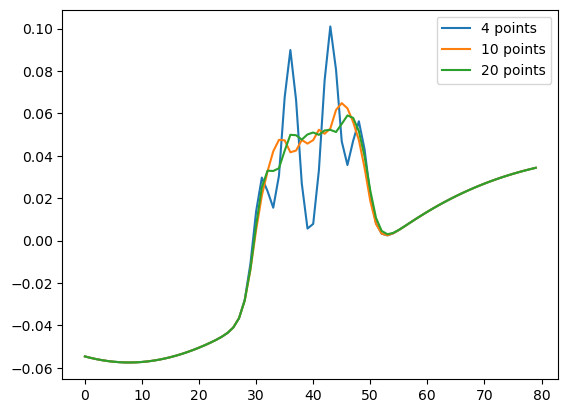

In [173]:
plt.plot(out4, label='4 points')
plt.plot(out10, label='10 points')
plt.plot(out20, label='20 points')
plt.legend()

In [178]:
y4 = gauss_quad_4(temp_fun, 0.0, 1.0)
y10 = gauss_quad_10(temp_fun, 0.0, 1.0)
y20 = gauss_quad_20(temp_fun, 0.0, 1.0)

w = 10000
print(w*y4**2, w*y10**2, w*y20**2)

63.30743705044989 63.079755860832066 38.34024276639653


### Add integral of divP as a loss term

In [364]:
def get_stress_neoHook(x, Lambda_params):
    eps = jnp.interp(x, x_gt, eps_gt)
    lmb = 1.0+eps
    mu = ff_nn(x, Lambda_params)
    sgmx = mu*lmb**2 - mu/lmb
    return sgmx[0]

divergence_1d = vmap(grad(get_stress_neoHook, argnums=0), in_axes=(0,None), out_axes=0)


w1 = 10.0
w2 = 5000.0
# w3 = 1e4
w3 = 0.0
def loss(Lambda_params, input, key):
    # get divergence across the domain
    x_colloc = random.uniform(key, (20,1))
    div = divergence_1d(x_colloc, Lambda_params)

    # get integrated div
    f = lambda x: divergence_1d(x[:,None], Lambda_params)
    l_window = 0.6
    a = random.uniform(key, minval=0.0, maxval=1.0-l_window)
    b = a + l_window
    div2 = gauss_quad_20(f, a, b)

    # get stress at 0 & L
    sgm0 = get_stress_neoHook(x_gt[ 0,None], Lambda_params)
    sgmL = get_stress_neoHook(x_gt[-1,None], Lambda_params)
    return w1*jnp.sum(div**2) + w2*((sgm0*1 - Fx)**2 + (sgmL*1-Fx)**2) + w3*div2**2

n_ff = 10
ff_params = np.random.normal(size=n_ff).reshape([1,n_ff])
nn_layers = [2*n_ff,5,3,1]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]

lr = optimizers.exponential_decay(1e-5, 1000, 0.9)
opt_init, opt_update, get_params = optimizers.adam(1.e-5) #prev lr = 1.e-5
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, metrics = train(loss, None, get_params, opt_update, opt_state, key, nIter = 500000, print_freq=10000)

it 10000, train loss = 2.325480e+03
it 20000, train loss = 4.864741e+02
it 30000, train loss = 2.772993e+02
it 40000, train loss = 1.264873e+02
it 50000, train loss = 8.817925e+01
it 60000, train loss = 1.353731e+02
it 70000, train loss = 1.061778e+02
it 80000, train loss = 2.000486e+02
it 90000, train loss = 4.744677e+01
it 100000, train loss = 9.225984e+01
it 110000, train loss = 4.784121e+01
it 120000, train loss = 1.095746e+02
it 130000, train loss = 9.033308e+01
it 140000, train loss = 5.089040e+01
it 150000, train loss = 4.497572e+01
it 160000, train loss = 2.558214e+02
it 170000, train loss = 2.780348e+02
it 180000, train loss = 7.993424e+01
it 190000, train loss = 2.721501e+02
it 200000, train loss = 7.143424e+01
it 210000, train loss = 5.006385e+01
it 220000, train loss = 1.392981e+02
it 230000, train loss = 2.175464e+01
it 240000, train loss = 2.758165e+01
it 250000, train loss = 1.919079e+01
it 260000, train loss = 3.612144e+01
it 270000, train loss = 3.162626e+01
it 280000,

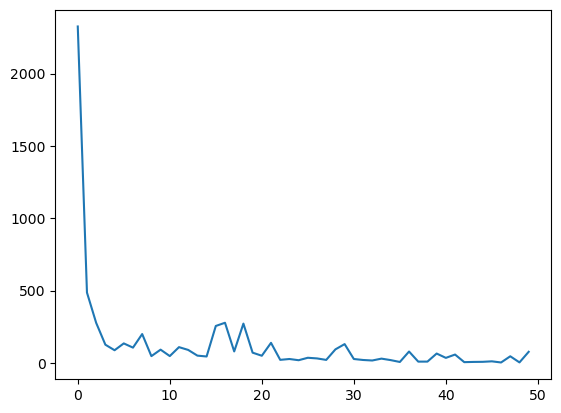

In [365]:
plt.plot(train_loss)

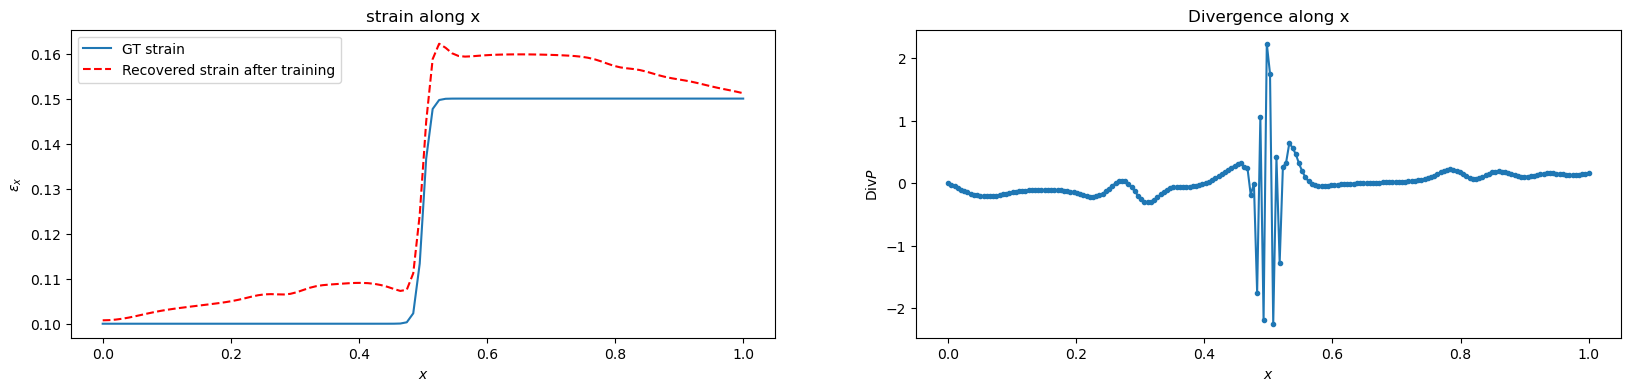

In [366]:
def get_strain_neoHook(x, Lambda_params): # Invert the get_stress_neoHook function to get the strain for a given stress
    sgmx = Fx/1.0 #stress is constant for the domain
    mu = ff_nn(x, Lambda_params)
    
    invertsgm = lambda lmb: mu*lmb**2 - mu/lmb - sgmx
    lmb = fsolve(invertsgm, x0 = 1.0)
    return lmb-1.0

eps_pr = []
for i in range(len(x_gt)):
    eps_pr.append(get_strain_neoHook(x_gt[i,None], Lambda_params)[0])


fig, ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(x_gt, eps_gt, label='GT strain')
ax[0].plot(x_gt, eps_pr, 'r--', label='Recovered strain after training')
ax[0].set(xlabel = '$x$', ylabel = '$\epsilon_{x}$', title='strain along x')
ax[0].legend()


x = np.linspace(0,1,200)
div = divergence_1d(x[:,None], Lambda_params)
ax[1].plot(x, div, '.-')
ax[1].set(xlabel = '$x$', ylabel='Div$P$', title='Divergence along x'); 

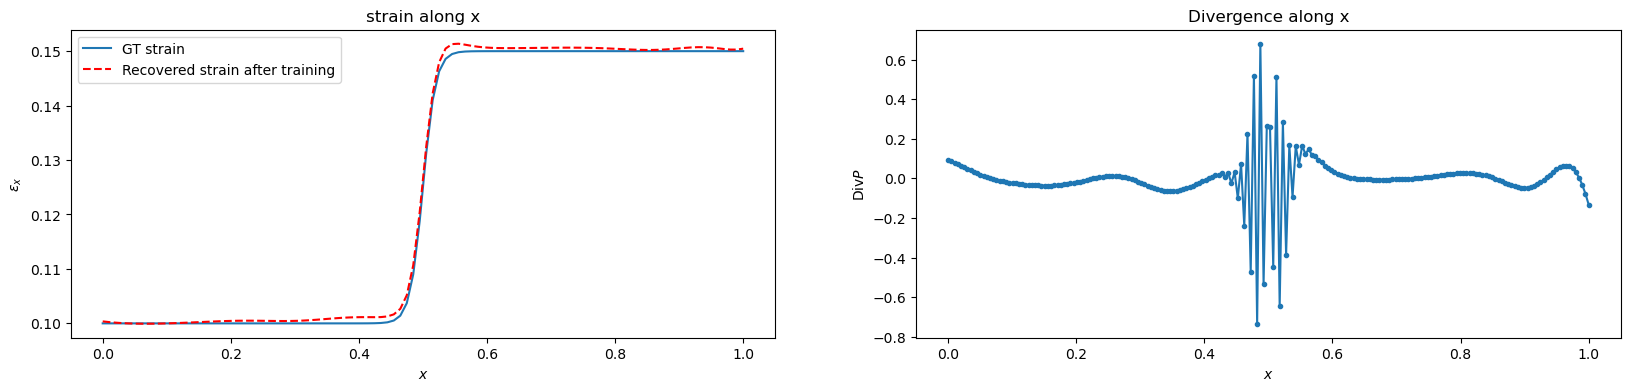

In [352]:
def get_strain_neoHook(x, Lambda_params): # Invert the get_stress_neoHook function to get the strain for a given stress
    sgmx = Fx/1.0 #stress is constant for the domain
    mu = ff_nn(x, Lambda_params)
    
    invertsgm = lambda lmb: mu*lmb**2 - mu/lmb - sgmx
    lmb = fsolve(invertsgm, x0 = 1.0)
    return lmb-1.0

eps_pr = []
for i in range(len(x_gt)):
    eps_pr.append(get_strain_neoHook(x_gt[i,None], Lambda_params)[0])


fig, ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(x_gt, eps_gt, label='GT strain')
ax[0].plot(x_gt, eps_pr, 'r--', label='Recovered strain after training')
ax[0].set(xlabel = '$x$', ylabel = '$\epsilon_{x}$', title='strain along x')
ax[0].legend()


x = np.linspace(0,1,200)
div = divergence_1d(x[:,None], Lambda_params)
ax[1].plot(x, div, '.-')
ax[1].set(xlabel = '$x$', ylabel='Div$P$', title='Divergence along x'); 

In [282]:
temp_fun = lambda x: divergence_1d(x[:,None], Lambda_params)
y4 = gauss_quad_4(temp_fun, 0.0, 1.0)
y10 = gauss_quad_10(temp_fun, 0.0, 1.0)
y20 = gauss_quad_20(temp_fun, 0.0, 1.0)

print(y4, y10, y20)
print(w3*y4**2, w3*y10**2, w3*y20**2)

-0.006878710962406502 0.0025375369099779194 -0.048225379806174834
0.4731666450433139 0.06439093569500287 23.256872574498153
